# Rule-Based Classification for Calculating Potential Customer Return

# The Business Problem
- (level based) create new sales definitions and create new
segments according to their definitions and create new segments according to these segments.
how much the company can earn on average from prospective customers
wants to predict.
- For example:
If you want to go to an All Inclusive hotel in Antalya during a busy period
determine how much a customer can earn on average
is requested.

# The Data Set Story
- You can see the prices of the sales made by the Gezinomi company and these
  contains information about sales. The data set consists of records generated in each sales transaction.
  is occurring.
  
- SaleId: Sales ID
- SaleDate: Date of the sale
- Price: Price paid for the sale
- ConceptName: Hotel concept information
- SaleCityName: City where the hotel is located
- CheckInDate: Customer's check-in date to the hotel
- CInDay: Day of the week for the customer's hotel check-in
- SaleCheckInDayDiff: Number of days between the check-in date and the sale date
- Season: Season information for the check-in date at the hotel

In [1]:
# import Required Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import warnings
warnings.simplefilter(action="ignore")

In [2]:
# Adjusting Row Column Settings
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.float_format", lambda x: '%.2f' % x)

In [3]:
# Loading the Data Set
df = pd.read_excel("/kaggle/input/gzmn01/gezinomi.xlsx")

In [4]:
df.head()

,SaleId,SaleDate,CheckInDate,Price,ConceptName,SaleCityName,CInDay,SaleCheckInDayDiff,Seasons
0,415122,2022-12-03,2022-12-03,79.30,Herşey Dahil,Antalya,Saturday,0,Low
1,415103,2022-12-03,2022-12-03,45.97,Yarım Pansiyon,Antalya,Saturday,0,Low
2,404034,2022-09-12,2022-09-13,77.84,Herşey Dahil,Antalya,Tuesday,1,High
3,415094,2022-12-03,2022-12-10,222.71,Yarım Pansiyon,İzmir,Saturday,7,Low
4,414951,2022-12-01,2022-12-03,140.48,Yarım Pansiyon,İzmir,Saturday,2,Low


In [5]:
# To drop the "SaleId" variable from the dataset
df = df.drop("SaleId", axis=1)

In [6]:
# To split the "SaleDate" variable into separate year, month, and day variables
df['SaleYear'] = df['SaleDate'].dt.year
df['SaleMonth'] = df['SaleDate'].dt.month
df['SaleDay'] = df['SaleDate'].dt.day

In [7]:
# To drop the "SaleDate" variable from the dataset
df = df.drop("SaleDate", axis=1)

In [8]:
# Preliminary examination of the data set
def check_df(dataframe, head=5):
    print('##################### Shape #####################')
    print(dataframe.shape)
    print('##################### Types #####################')
    print(dataframe.dtypes)
    print('##################### Head #####################')
    print(dataframe.head(head))
    print('##################### Tail #####################')
    print(dataframe.tail(head))
    print('##################### NA #####################')
    print(dataframe.isnull().sum())
    print('##################### Quantiles #####################')
    print(dataframe.describe([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

check_df(df)

##################### Shape #####################
(59164, 10)
##################### Types #####################
CheckInDate           datetime64[ns]
Price                        float64
ConceptName                   object
SaleCityName                  object
CInDay                        object
SaleCheckInDayDiff             int64
Seasons                       object
SaleYear                       int64
SaleMonth                      int64
SaleDay                        int64
dtype: object
##################### Head #####################
  CheckInDate  Price     ConceptName SaleCityName    CInDay  \
0  2022-12-03  79.30    Herşey Dahil      Antalya  Saturday   
1  2022-12-03  45.97  Yarım Pansiyon      Antalya  Saturday   
2  2022-09-13  77.84    Herşey Dahil      Antalya   Tuesday   
3  2022-12-10 222.71  Yarım Pansiyon        İzmir  Saturday   
4  2022-12-03 140.48  Yarım Pansiyon        İzmir  Saturday   

   SaleCheckInDayDiff Seasons  SaleYear  SaleMonth  SaleDay  
0             

In [9]:
# Filling the empty observations of the Price variable with the mean.
df['Price'].fillna(df['Price'].mean(), inplace=True)

In [10]:
# Examination of numerical and categorical variables
def grab_col_names(dataframe, cat_th=10, car_th=20):
    """
    Returns the names of categorical, numeric and categorical but cardinal variables in the data set.
    Note Categorical variables include categorical variables with numeric appearance.
    Parameters
    ------
         dataframe: dataframe
                Dataframe to get variable names
        cat_th: int, optional
                class threshold for numeric but categorical variables
        car_th: int, optinal
                class threshold for categorical but cardinal variables
    Returns
    ------
        cat_cols: list
                Categorical variable list
        num_cols: list
                Numeric variable list
        cat_but_car: list
                List of cardinal variables with categorical view
    Examples
    ------
        import seaborn as sns
        df = sns.load_dataset("iris")
        print(grab_col_names(df))
    Notes
    ------
        cat_cols + num_cols + cat_but_car = total number of variables
        num_but_cat is inside cat_cols.
        The sum of the 3 return lists equals the total number of variables: cat_cols + num_cols + cat_but_car = number of variables
    """

    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == 'O']
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != 'O']
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == 'O']
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != 'O']
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f'Observations: {dataframe.shape[0]}')
    print(f'Variables: {dataframe.shape[1]}')
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car, num_but_cat

cat_cols, num_cols, cat_but_car, num_but_cat = grab_col_names(df)

Observations: 59164
Variables: 10
cat_cols: 5
num_cols: 5
cat_but_car: 0
num_but_cat: 1


                ConceptName  Ratio
Herşey Dahil          53186  89.90
Yarım Pansiyon         3559   6.02
Oda + Kahvaltı         2419   4.09
##########################################


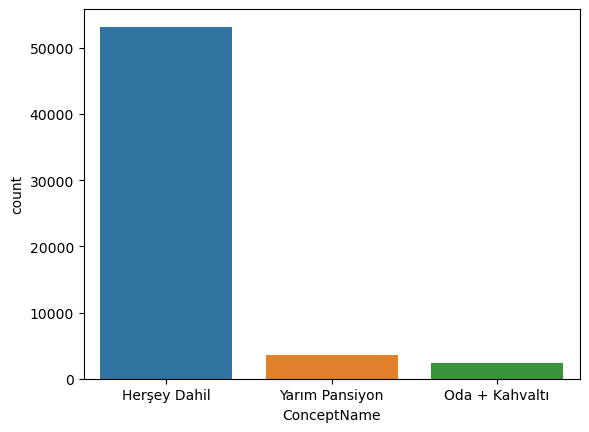

         SaleCityName  Ratio
Antalya         31649  53.49
Muğla           10662  18.02
Aydın           10646  17.99
Diğer            3245   5.48
İzmir            2507   4.24
Girne             455   0.77
##########################################


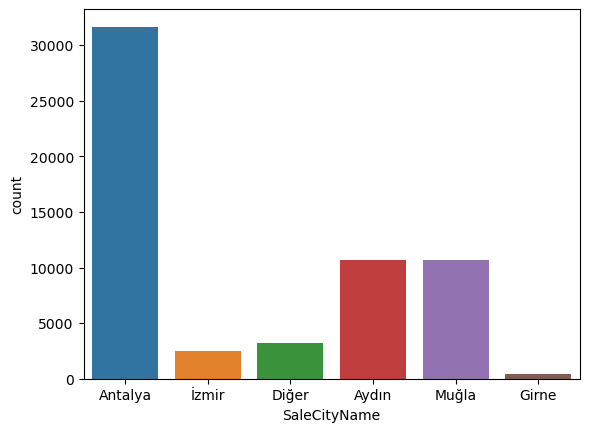

           CInDay  Ratio
Monday      12794  21.62
Saturday     9967  16.85
Friday       8683  14.68
Thursday     7314  12.36
Sunday       7050  11.92
Tuesday      6807  11.51
Wednesday    6549  11.07
##########################################


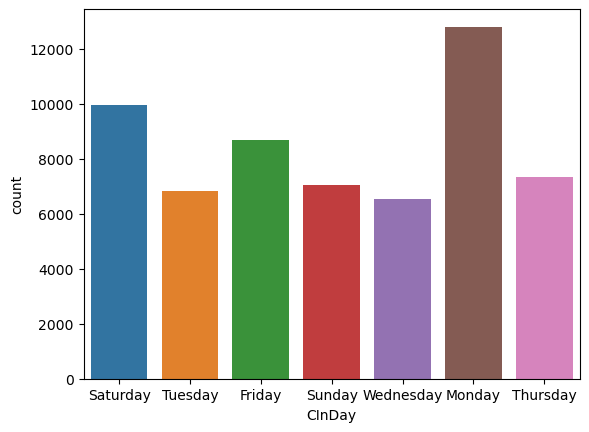

      Seasons  Ratio
High    50946  86.11
Low      8218  13.89
##########################################


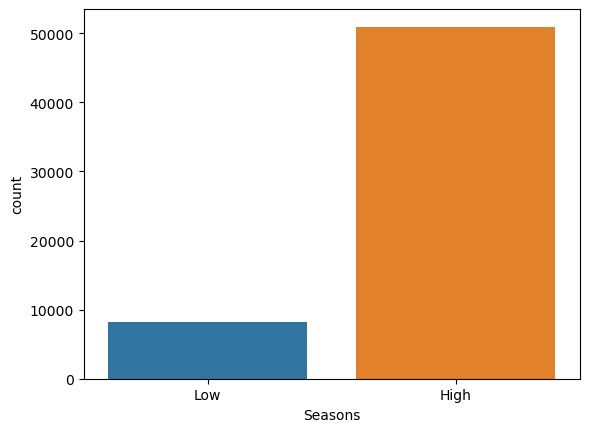

      SaleYear  Ratio
2022     22536  38.09
2021     19159  32.38
2020      6992  11.82
2016      2892   4.89
2018      2723   4.60
2017      2656   4.49
2019      2206   3.73
##########################################


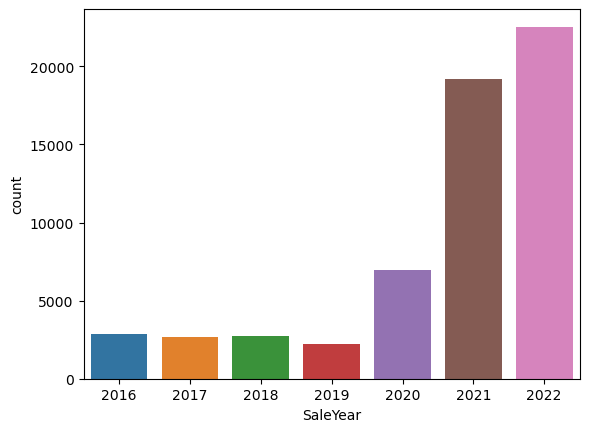

In [11]:
# Categorical variable analysis
def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        'Ratio': 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print('##########################################')
    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show(block=True)

for col in cat_cols:
    cat_summary(df, col, plot=True)

count                   59164
unique                   2173
top       2022-08-22 00:00:00
freq                      405
first     2007-07-20 00:00:00
last      2023-08-16 00:00:00
Name: CheckInDate, dtype: object


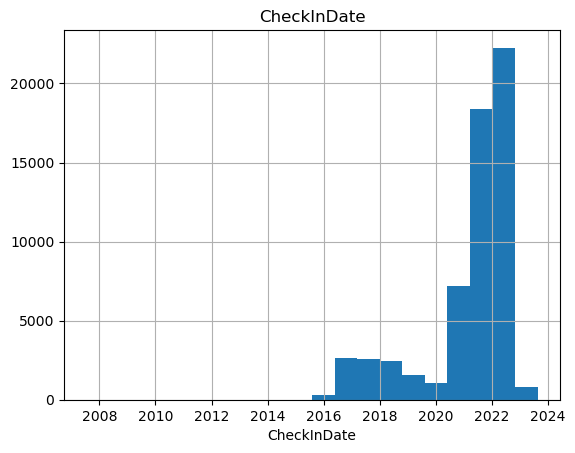

count   59164.00
mean       61.35
std        51.38
min         0.00
5%         19.64
10%        24.46
20%        31.80
30%        39.17
40%        46.36
50%        54.27
60%        61.86
70%        72.21
80%        84.85
90%       106.29
95%       125.45
99%       172.74
max      4880.47
Name: Price, dtype: float64


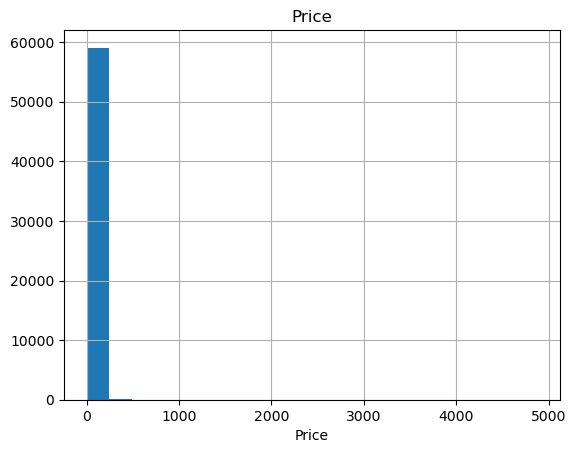

count   59164.00
mean       31.84
std        51.49
min         0.00
5%          0.00
10%         1.00
20%         2.00
30%         3.00
40%         6.00
50%        10.00
60%        16.00
70%        26.00
80%        46.00
90%       103.00
95%       157.00
99%       223.00
max       630.00
Name: SaleCheckInDayDiff, dtype: float64


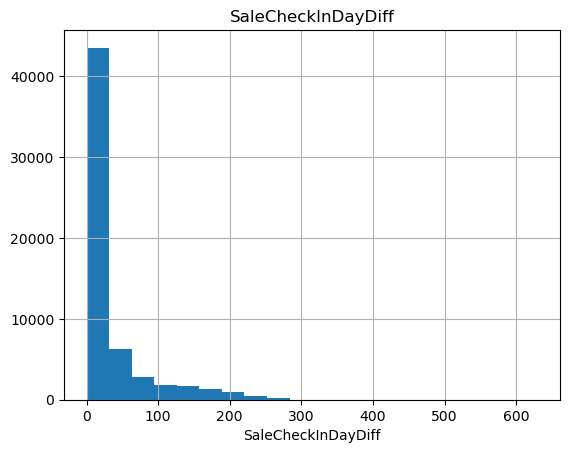

count   59164.00
mean        6.41
std         2.44
min         1.00
5%          2.00
10%         3.00
20%         4.00
30%         5.00
40%         6.00
50%         7.00
60%         7.00
70%         8.00
80%         8.00
90%         9.00
95%        10.00
99%        12.00
max        12.00
Name: SaleMonth, dtype: float64


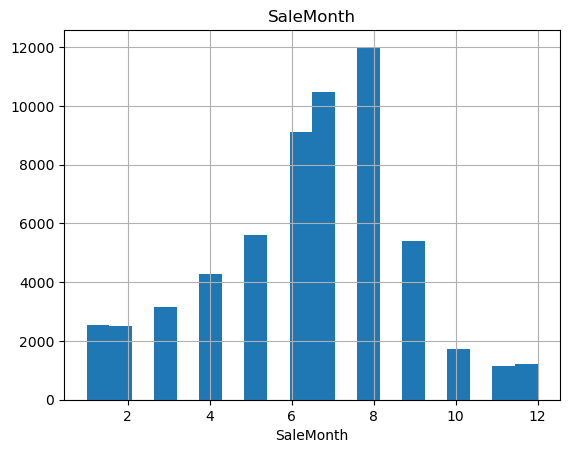

count   59164.00
mean       15.88
std         8.82
min         1.00
5%          2.00
10%         4.00
20%         7.00
30%        10.00
40%        13.00
50%        16.00
60%        19.00
70%        22.00
80%        25.00
90%        28.00
95%        30.00
99%        31.00
max        31.00
Name: SaleDay, dtype: float64


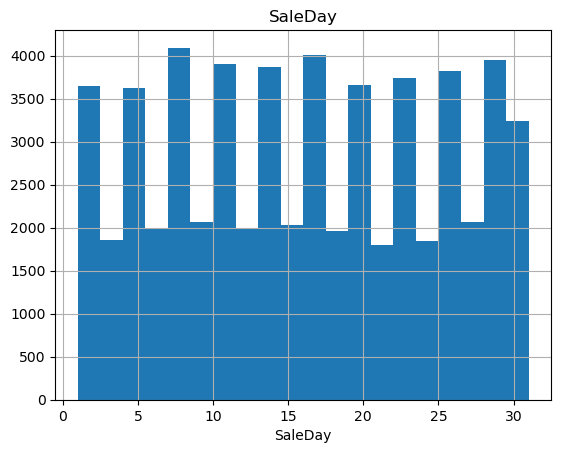

In [12]:
# Numerical variable analysis
def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        dataframe[numerical_col].hist(bins=20)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show(block=True)

for col in num_cols:
    num_summary(df, col, plot=True)

                TARGET_MEAN
ConceptName                
Herşey Dahil          62.67
Oda + Kahvaltı        50.27
Yarım Pansiyon        49.04




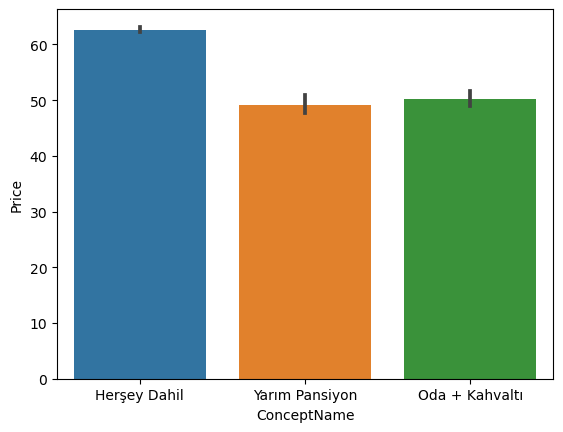

              TARGET_MEAN
SaleCityName             
Antalya             64.52
Aydın               53.86
Diğer               47.73
Girne               59.48
Muğla               62.46
İzmir               66.26




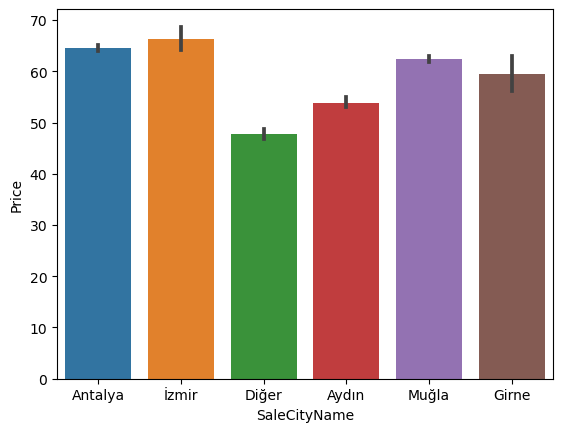

           TARGET_MEAN
CInDay                
Friday           58.76
Monday           61.23
Saturday         60.42
Sunday           62.97
Thursday         60.57
Tuesday          63.45
Wednesday        63.34




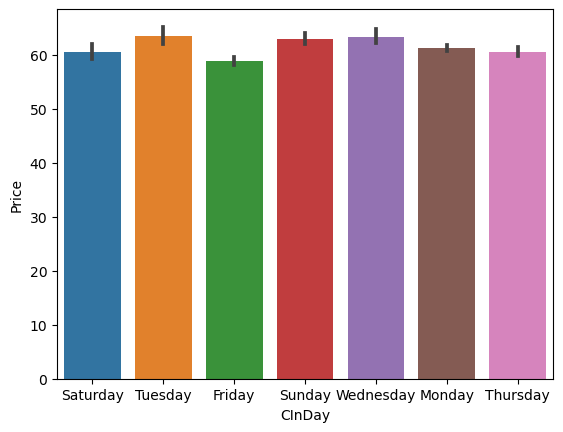

         TARGET_MEAN
Seasons             
High           62.48
Low            54.29




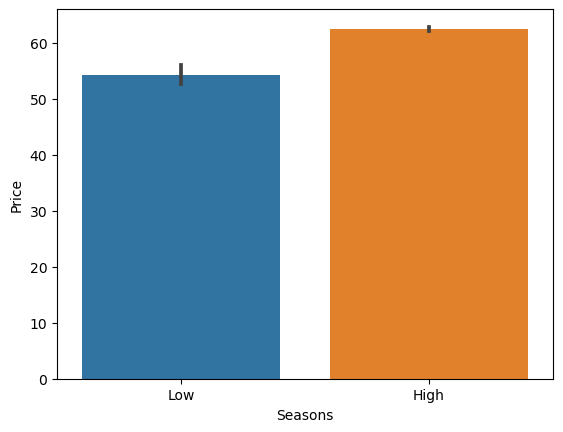

          TARGET_MEAN
SaleYear             
2016            71.35
2017            67.33
2018            61.06
2019            76.40
2020            52.65
2021            60.56
2022            61.28




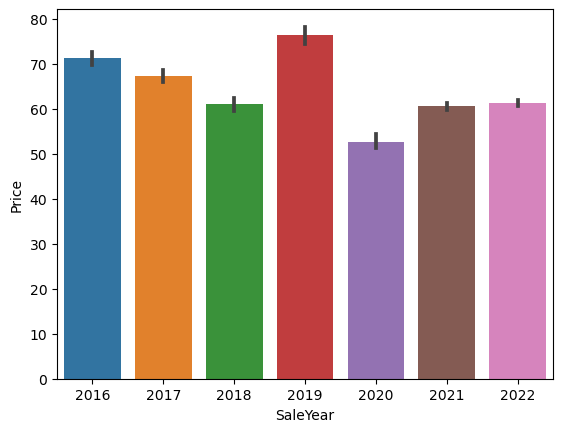

In [13]:
# Analysis of categorical variables by target variable
def target_summary_with_cat(dataframe, target, categorical_col, plot=False):
    print(pd.DataFrame({'TARGET_MEAN': dataframe.groupby(categorical_col)[target].mean()}), end='\n\n\n')
    if plot:
        sns.barplot(x=categorical_col, y=target, data=dataframe)
        plt.show(block=True)

for col in cat_cols:
    target_summary_with_cat(df, 'Price', col, plot=True)

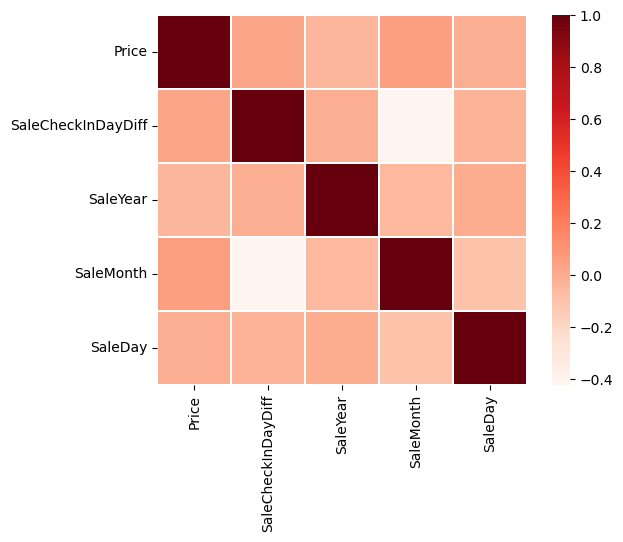

SaleCheckInDayDiff  SaleMonth            0.42
SaleMonth           SaleDay              0.10
SaleYear            SaleMonth            0.06
Price               SaleMonth            0.06
                    SaleYear             0.04
SaleCheckInDayDiff  SaleDay              0.03
Price               SaleCheckInDayDiff   0.02
SaleCheckInDayDiff  SaleYear             0.01
Price               SaleDay              0.01
SaleYear            SaleDay              0.00
dtype: float64

In [14]:
# Correlation Analysis of the Variables
def df_corr(dataframe, annot=True):
    sns.heatmap(dataframe.corr(), annot=annot, linewidths=.2, cmap='Reds', square=True)
    plt.show(block=True)

def high_correlated_cols(dataframe,head=10):
    corr_matrix = dataframe.corr().abs()
    corr_cols = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1)
                                   .astype(bool)).stack().sort_values(ascending=False)).head(head)
    return corr_cols

df_corr(df, annot=False)
high_correlated_cols(df, 15)

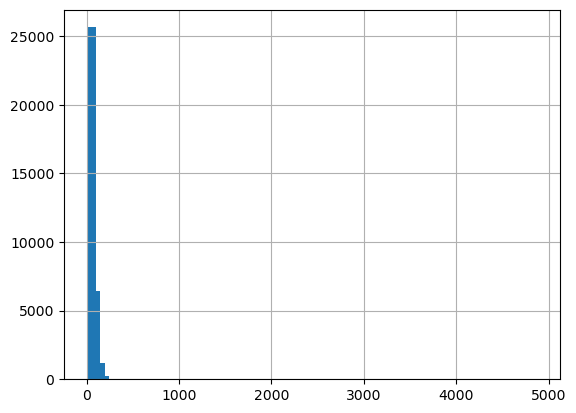

In [15]:
# Examination of the dependent variable
df["Price"].hist(bins=100)
plt.show(block=True)

In [16]:
# What is the total amount earned from sales by city?
df.groupby("SaleCityName").agg({"Price": "sum"})

,Price
SaleCityName,
Antalya,2042033.79
Aydın,573357.35
Diğer,154879.02
Girne,27065.03
Muğla,665964.90
İzmir,166118.87


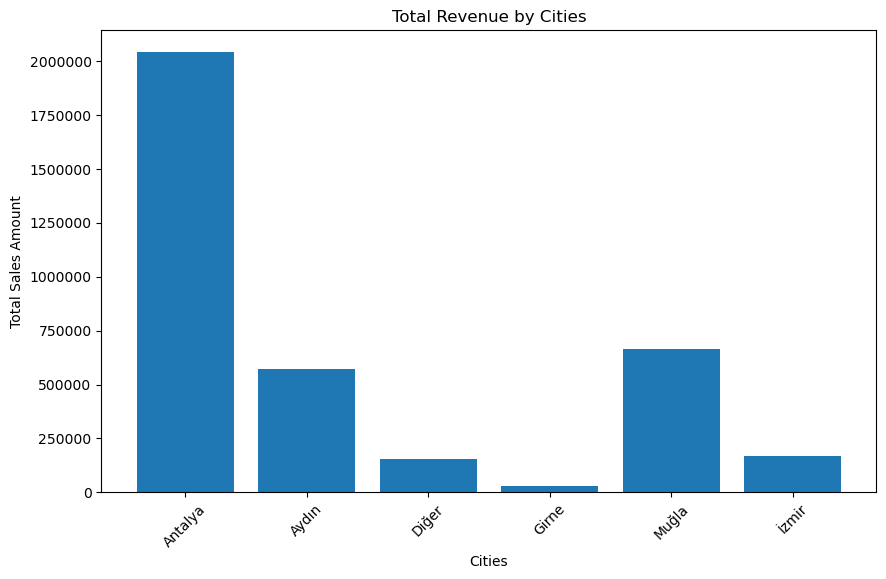

In [17]:
# Calculating the total sales amount by grouping the data
sales_by_city = df.groupby("SaleCityName")["Price"].sum()

# Setting the x and y axes for the graph
x = sales_by_city.index
y = sales_by_city.values

# Setting the size of the graph
plt.figure(figsize=(10, 6))

# Plotting the bar chart
plt.bar(x, y)

# Adding axis labels and a title to the graph
plt.xlabel("Cities")
plt.ylabel("Total Sales Amount")
plt.title("Total Revenue by Cities")

# Rotating the axis labels
plt.xticks(rotation=45)

plt.ticklabel_format(style='plain', axis='y')

# Displaying the graph
plt.show()


In [18]:
df.groupby(by=["SaleCityName"]).agg({"Price": "mean"})

,Price
SaleCityName,
Antalya,64.52
Aydın,53.86
Diğer,47.73
Girne,59.48
Muğla,62.46
İzmir,66.26


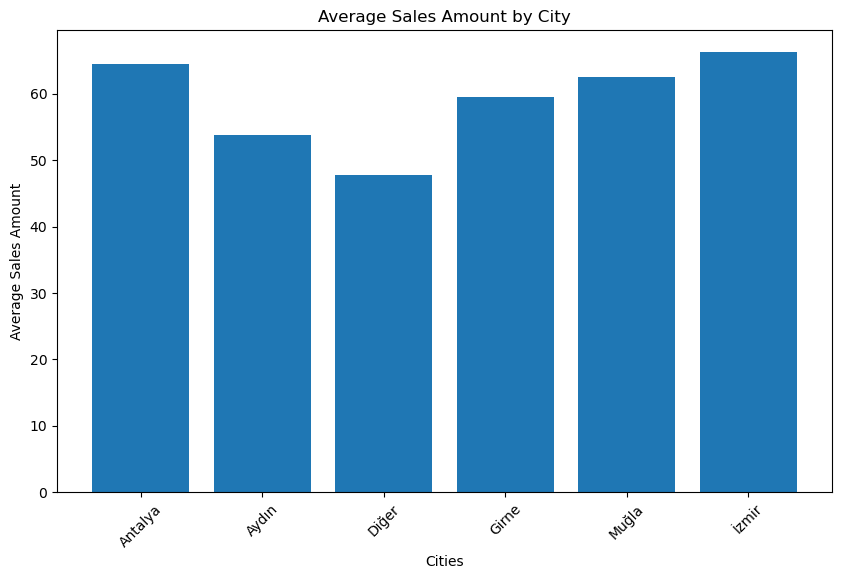

In [19]:
# Calculating the average sales amount by grouping the data by city
mean_sales_by_city = df.groupby("SaleCityName")["Price"].mean()

# Setting up the x and y axes for the plot
x = mean_sales_by_city.index
y = mean_sales_by_city.values

# Adjusting the size of the plot
plt.figure(figsize=(10, 6))

# Plotting the bar chart
plt.bar(x, y)

# Adding axis labels and a title to the plot
plt.xlabel("Cities")
plt.ylabel("Average Sales Amount")
plt.title("Average Sales Amount by City")

# Rotating the axis labels
plt.xticks(rotation=45)

# Displaying the plot
plt.show()



In [20]:
# How much is earned by ConceptName types?
df.groupby("ConceptName").agg({"Price": "sum"})

,Price
ConceptName,
Herşey Dahil,3333278.84
Oda + Kahvaltı,121615.08
Yarım Pansiyon,174525.04


In [21]:
# Calculating the average PRICE by grouping the data by SaleCityName and ConceptName
mean_price_by_city_concept = df.groupby(["SaleCityName", "ConceptName"]).agg({"Price": "mean"}).reset_index()

# Creating the plot
fig = px.bar(mean_price_by_city_concept, x="SaleCityName", y="Price", color="ConceptName",
             title="Average PRICE by City-Concept")

# Setting the axis labels
fig.update_layout(xaxis_title="City", yaxis_title="Average PRICE")

# Displaying the plot
fig.show()

In [22]:
# Creating a new categorical variable named "EB_Score" using the "satis_checkin_day_diff" variable
bins = [-1, 7, 30, 90, df["SaleCheckInDayDiff"].max()]  # Define the intervals to be used for binning.
labels = ["Last Minutes", "Potential Planners", "Planners", "Early Bookers"]  # Define the labels for the intervals.
df["EB_Score"] = pd.cut(df["SaleCheckInDayDiff"], bins, labels=labels)  # Create a new categorical variable named "EB_Score" using the "satis_checkin_day_diff" variable.
df.head()


,CheckInDate,Price,ConceptName,SaleCityName,CInDay,SaleCheckInDayDiff,Seasons,SaleYear,SaleMonth,SaleDay,EB_Score
0,2022-12-03,79.30,Herşey Dahil,Antalya,Saturday,0,Low,2022,12,3,Last Minutes
1,2022-12-03,45.97,Yarım Pansiyon,Antalya,Saturday,0,Low,2022,12,3,Last Minutes
2,2022-09-13,77.84,Herşey Dahil,Antalya,Tuesday,1,High,2022,9,12,Last Minutes
3,2022-12-10,222.71,Yarım Pansiyon,İzmir,Saturday,7,Low,2022,12,3,Last Minutes
4,2022-12-03,140.48,Yarım Pansiyon,İzmir,Saturday,2,Low,2022,12,1,Last Minutes


In [23]:
# Here, this new variable we created is printed to the excel file.
#df.to_excel("eb_scorew.xlsx", index=False)

In [24]:
# Average salaries by City-Concept-EB Score
df.groupby(["SaleCityName", "ConceptName", "EB_Score"]).agg({"Price": ["mean", "count"]})

Price       
                                                 mean  count
SaleCityName ConceptName    EB_Score                        
Antalya      Herşey Dahil   Last Minutes        62.75  14148
                            Potential Planners  64.90   8876
                            Planners            67.88   4490
                            Early Bookers       66.49   3281
             Oda + Kahvaltı Last Minutes        65.35    503
                            Potential Planners  57.74     75
                            Planners            39.85     15
                            Early Bookers       35.00      5
             Yarım Pansiyon Last Minutes        70.43    204
                            Potential Planners  55.64     39
                            Planners            58.03      9
                            Early Bookers       35.03      4
Aydın        Herşey Dahil   Last Minutes        51.71   3966
                            Potential Planners  52.09   2717
                            Planners            57.88   1834
                            Early Bookers       57.44   2060
             Oda + Kahvaltı Last Minutes        37.80     20
                            Potential Planners  31.08     15
                            Planners            30.20      2
                            Early Bookers       26.81      1
             Yarım Pansiyon Last Minutes        30.87     18
                            Potential Planners  23.73      6
                            Planners            28.81      6
                            Early Bookers       59.60      1
Diğer        Herşey Dahil   Last Minutes        75.47    155
                            Potential Planners  85.79    129
                            Planners            87.26    120
                            Early Bookers       94.46    102
             Oda + Kahvaltı Last Minutes        38.24    542
                            Potential Planners  34.98    176
                            Planners            43.96     35
                            Early Bookers       35.72      8
             Yarım Pansiyon Last Minutes        39.47   1173
                            Potential Planners  45.70    605
                            Planners            46.14    173
                            Early Bookers       50.68     27
Girne        Herşey Dahil   Last Minutes        93.25     24
                            Potential Planners  94.95     41
                            Planners           103.41     25
                            Early Bookers      102.38     16
             Oda + Kahvaltı Last Minutes        37.58     62
                            Potential Planners  39.77     39
                            Planners            43.15     28
                            Early Bookers       43.97     10
             Yarım Pansiyon Last Minutes        60.86     73
                            Potential Planners  53.40     81
                            Planners            45.99     43
                            Early Bookers       33.60     13
Muğla        Herşey Dahil   Last Minutes        63.69   3851
                            Potential Planners  62.41   2943
                            Planners            63.44   1959
                            Early Bookers       61.52   1067
             Oda + Kahvaltı Last Minutes        51.09    331
                            Potential Planners  63.11    149
                            Planners            72.30    122
                            Early Bookers       66.76     53
             Yarım Pansiyon Last Minutes        41.88    104
                            Potential Planners  45.29     50
                            Planners            52.80     24
                            Early Bookers       61.14      9
İzmir        Herşey Dahil   Last Minutes        73.23    590
                            Potential Planners  67.77    440
                            Planners            80.04    231
                      

In [25]:
# Average salaries by City-Concept-EB Score
mean_count_price_by_city_concept_eb = df.groupby(["SaleCityName", "ConceptName", "EB_Score"]).agg({"Price": ["mean", "count"]}).reset_index()
mean_count_price_by_city_concept_eb.columns = ["SaleCityName", "ConceptName", "EB_Score", "Mean_Price", "Count"]

# Graph creation
fig = px.bar(mean_count_price_by_city_concept_eb, x="SaleCityName", y="Mean_Price", color="EB_Score",
             facet_col="ConceptName",
             title="Average Prices by City-Concept-EB Score",
             labels={"EB_Score": "EB Score", "Mean_Price": "Average Price"},
             hover_data=["Count"])

# Updating axis labels
fig.update_layout(xaxis_title="SaleCityName", yaxis_title="Average Price")

# Showing the graph
fig.show()


In [26]:
# Average prices by City-Concept-Season breakdown
df.groupby(["SaleCityName", "ConceptName", "Seasons"]).agg({"Price": ["mean", "count"]})

Price       
                                      mean  count
SaleCityName ConceptName    Seasons              
Antalya      Herşey Dahil   High     64.92  27126
                            Low      61.55   3669
             Oda + Kahvaltı High     66.27    303
                            Low      60.67    295
             Yarım Pansiyon High     73.26    118
                            Low      62.00    138
Aydın        Herşey Dahil   High     54.95  10104
                            Low      33.68    473
             Oda + Kahvaltı High     30.39     27
                            Low      44.45     11
             Yarım Pansiyon High     32.63     20
                            Low      25.27     11
Diğer        Herşey Dahil   High     83.73    365
                            Low      87.31    141
             Oda + Kahvaltı High     35.07    352
                            Low      40.01    409
             Yarım Pansiyon High     39.73    516
                            Low      42.95   1462
Girne        Herşey Dahil   High    103.94     55
                            Low      90.94     51
             Oda + Kahvaltı High     39.48     66
                            Low      40.04     73
             Yarım Pansiyon High     58.38    100
                            Low      48.58    110
Muğla        Herşey Dahil   High     63.38   9583
                            Low      48.30    237
             Oda + Kahvaltı High     61.26    593
                            Low      37.77     62
             Yarım Pansiyon High     45.82    177
                            Low      32.68     10
İzmir        Herşey Dahil   High     74.74   1235
                            Low      74.31    147
             Oda + Kahvaltı High     54.14     86
                            Low      33.56    142
             Yarım Pansiyon High     87.22    120
                            Low      55.35    777

In [27]:
# Calculating the mean prices and counts by SaleCityName, ConceptName, and Seasons
mean_count_price_by_city_concept_seasons = df.groupby(["SaleCityName", "ConceptName", "Seasons"]).agg({"Price": ["mean", "count"]}).reset_index()
mean_count_price_by_city_concept_seasons.columns = ["SaleCityName", "ConceptName", "Seasons", "Mean_Price", "Count"]

# Creating the plot
fig = px.bar(mean_count_price_by_city_concept_seasons, x="SaleCityName", y="Mean_Price", color="Seasons",
             facet_col="ConceptName",
             title="Average Prices by City-Concept-Season",
             labels={"Seasons": "Season", "Mean_Price": "Average Price"},
             hover_data=["Count"])

# Updating axis labels
fig.update_layout(xaxis_title="SaleCityName", yaxis_title="Average Price")

# Showing the plot
fig.show()


In [28]:
#Average Prices by City-Concept-CInDay Breakdown
df.groupby(["SaleCityName", "ConceptName", "CInDay"]).agg({"Price": ["mean", "count"]})

Price      
                                        mean count
SaleCityName ConceptName    CInDay                
Antalya      Herşey Dahil   Friday     62.66  4138
                            Monday     63.26  6831
                            Saturday   64.42  4741
                            Sunday     65.85  3818
                            Thursday   62.89  3898
                            Tuesday    66.77  3760
                            Wednesday  67.17  3609
             Oda + Kahvaltı Friday     63.13   114
                            Monday     57.17    66
                            Saturday   58.01   117
                            Sunday     63.47    46
                            Thursday   64.65    93
                            Tuesday    65.84    73
                            Wednesday  72.81    89
             Yarım Pansiyon Friday     69.26    38
                            Monday     76.95    20
                            Saturday   63.38    71
                            Sunday     64.45    30
                            Thursday   66.64    40
                            Tuesday    71.02    21
                            Wednesday  67.78    36
Aydın        Herşey Dahil   Friday     51.04  1826
                            Monday     54.38  2566
                            Saturday   56.89  1702
                            Sunday     53.19  1098
                            Thursday   54.51  1315
                            Tuesday    53.51  1098
                            Wednesday  54.22   972
             Oda + Kahvaltı Friday     31.17     7
                            Monday     45.40     7
                            Saturday   23.93     2
                            Sunday     43.53     3
                            Thursday   37.52     7
                            Tuesday    32.93     3
                            Wednesday  25.95     9
             Yarım Pansiyon Friday     24.52     5
                            Monday     43.43     3
                            Saturday   29.70     8
                            Sunday     30.28     3
                            Thursday   22.78     5
                            Tuesday    32.16     4
                            Wednesday  35.55     3
Diğer        Herşey Dahil   Friday     84.66    78
                            Monday     90.60   112
                            Saturday   77.23    90
                            Sunday     81.61    57
                            Thursday   76.11    54
                            Tuesday    89.82    57
                            Wednesday  91.18    58
             Oda + Kahvaltı Friday     38.47   116
                            Monday     36.65    87
                            Saturday   36.52   208
                            Sunday     38.06    67
                            Thursday   36.16   102
                            Tuesday    42.24    80
                            Wednesday  38.05   101
             Yarım Pansiyon Friday     42.37   407
                            Monday     40.28   217
                            Saturday   43.25   638
                            Sunday     41.86   219
                            Thursday   41.95   198
                            Tuesday    43.50   140
                            Wednesday  38.74   159
Girne        Herşey Dahil   Friday    121.19    12
                            Monday     98.66    22
                            Saturday  109.17     9
                            Sunday     85.19    38
                            Thursday  112.38     7
                            Tuesday   111.40     8
                            Wednesday  83.17    10
             Oda + Kahvaltı Friday     45.02    34
                            Monday     40.76    13
                            Saturday   37.18    29
                            Sunday     38.22    20
                            Thursday   36.50    13
                            Tuesday    35.39    19
          

In [29]:
# Calculating the mean prices and counts by SaleCityName, ConceptName, and CInDay
mean_count_price_by_city_concept_cinday = df.groupby(["SaleCityName", "ConceptName", "CInDay"]).agg({"Price": ["mean", "count"]}).reset_index()
mean_count_price_by_city_concept_cinday.columns = ["SaleCityName", "ConceptName", "CInDay", "Mean_Price", "Count"]

# Creating the plot
fig = px.bar(mean_count_price_by_city_concept_cinday, x="SaleCityName", y="Mean_Price", color="CInDay",
             facet_col="ConceptName",
             title="Average Prices by City-Concept-CInDay",
             labels={"CInDay": "CInDay", "Mean_Price": "Average Price"},
             hover_data=["Count"])

# Updating axis labels
fig.update_layout(xaxis_title="SaleCityName", yaxis_title="Average Price")

# Showing the plot
fig.show()



In [30]:
df.groupby(["SaleYear", "ConceptName", "SaleCityName"])["Price"].mean().reset_index().head()

,SaleYear,ConceptName,SaleCityName,Price
0,2016,Herşey Dahil,Antalya,71.34
1,2016,Herşey Dahil,Aydın,74.96
2,2016,Herşey Dahil,Diğer,82.65
3,2016,Herşey Dahil,Girne,121.64
4,2016,Herşey Dahil,Muğla,84.30


In [31]:
# Grouping and calculating mean prices
mean_price_by_year_concept_city = df.groupby(["SaleYear", "ConceptName", "SaleCityName"])["Price"].mean().reset_index()

# Creating the chart
fig = px.bar(mean_price_by_year_concept_city, x="SaleYear", y="Price", color="ConceptName",
             facet_col="SaleCityName", title="Average Price by Year, Concept, and City",
             labels={"SaleYear": "Year", "Price": "Average Price"})

# Updating axis labels
fig.update_layout(xaxis_title="Year", yaxis_title="Average Price")

# Displaying the chart
fig.show()



In [32]:
# Sorting the output of the City-Concept-Season breakdown by PRICE
agg_df = df.groupby(["SaleCityName", "ConceptName", "Seasons"]).agg({"Price": "mean"}).sort_values("Price", ascending=False).head(20)
agg_df.reset_index(inplace=True)

In [33]:
agg_df

,SaleCityName,ConceptName,Seasons,Price
0,Girne,Herşey Dahil,High,103.94
1,Girne,Herşey Dahil,Low,90.94
2,Diğer,Herşey Dahil,Low,87.31
3,İzmir,Yarım Pansiyon,High,87.22
4,Diğer,Herşey Dahil,High,83.73
5,İzmir,Herşey Dahil,High,74.74
6,İzmir,Herşey Dahil,Low,74.31
7,Antalya,Yarım Pansiyon,High,73.26
8,Antalya,Oda + Kahvaltı,High,66.27
9,Antalya,Herşey Dahil,High,64.92


In [34]:
# Grouping and calculating mean prices
mean_price_by_city_concept_seasons = df.groupby(["SaleCityName", "ConceptName", "Seasons"]).agg({"Price": "mean"}).sort_values("Price", ascending=False).reset_index()

# Creating the chart
fig = px.bar(mean_price_by_city_concept_seasons, x="SaleCityName", y="Price", color="ConceptName",
             facet_col="Seasons", title="Average Price by City, Concept, and Seasons",
             labels={"SaleCityName": "City", "Price": "Average Price", "ConceptName": "Concept", "Seasons": "Season"})

# Updating axis labels
fig.update_layout(xaxis_title="City", yaxis_title="Average Price")

# Displaying the chart
fig.show()



In [35]:
# Defining new level based sales and adding them as variables to the data set
agg_df["sales_level_based"] = agg_df[["SaleCityName", "ConceptName", "Seasons"]].agg(lambda x: '_'.join(x).upper(), axis=1)

In [36]:
# Segmentation of persons
# Segmentation by price
agg_df["SEGMENT"] = pd.cut(agg_df["Price"], 4, labels=["D", "C", "B", "A"])
agg_df.head(30)

,SaleCityName,ConceptName,Seasons,Price,sales_level_based,SEGMENT
0,Girne,Herşey Dahil,High,103.94,GIRNE_HERŞEY DAHIL_HIGH,A
1,Girne,Herşey Dahil,Low,90.94,GIRNE_HERŞEY DAHIL_LOW,A
2,Diğer,Herşey Dahil,Low,87.31,DIĞER_HERŞEY DAHIL_LOW,B
3,İzmir,Yarım Pansiyon,High,87.22,İZMIR_YARIM PANSIYON_HIGH,B
4,Diğer,Herşey Dahil,High,83.73,DIĞER_HERŞEY DAHIL_HIGH,B
5,İzmir,Herşey Dahil,High,74.74,İZMIR_HERŞEY DAHIL_HIGH,C
6,İzmir,Herşey Dahil,Low,74.31,İZMIR_HERŞEY DAHIL_LOW,C
7,Antalya,Yarım Pansiyon,High,73.26,ANTALYA_YARIM PANSIYON_HIGH,C
8,Antalya,Oda + Kahvaltı,High,66.27,ANTALYA_ODA + KAHVALTI_HIGH,C
9,Antalya,Herşey Dahil,High,64.92,ANTALYA_HERŞEY DAHIL_HIGH,C


In [37]:
# Calculation of average max, min and total values in segment breakdown
agg_df.groupby("SEGMENT").agg({"Price": ["mean", "max", "min", "sum"]})

Price                    
         mean    max   min    sum
SEGMENT                          
D       57.43  62.00 48.58 516.89
C       69.48  74.74 63.38 416.88
B       86.09  87.31 83.73 258.26
A       97.44 103.94 90.94 194.87

In [38]:
# Sorting agg_df by price variable
agg_df.sort_values(by="Price")

,SaleCityName,ConceptName,Seasons,Price,sales_level_based,SEGMENT
19,Girne,Yarım Pansiyon,Low,48.58,GIRNE_YARIM PANSIYON_LOW,D
18,İzmir,Oda + Kahvaltı,High,54.14,İZMIR_ODA + KAHVALTI_HIGH,D
17,Aydın,Herşey Dahil,High,54.95,AYDIN_HERŞEY DAHIL_HIGH,D
16,İzmir,Yarım Pansiyon,Low,55.35,İZMIR_YARIM PANSIYON_LOW,D
15,Girne,Yarım Pansiyon,High,58.38,GIRNE_YARIM PANSIYON_HIGH,D
14,Antalya,Oda + Kahvaltı,Low,60.67,ANTALYA_ODA + KAHVALTI_LOW,D
13,Muğla,Oda + Kahvaltı,High,61.26,MUĞLA_ODA + KAHVALTI_HIGH,D
12,Antalya,Herşey Dahil,Low,61.55,ANTALYA_HERŞEY DAHIL_LOW,D
11,Antalya,Yarım Pansiyon,Low,62.00,ANTALYA_YARIM PANSIYON_LOW,D
10,Muğla,Herşey Dahil,High,63.38,MUĞLA_HERŞEY DAHIL_HIGH,C


In [39]:
# example
new_user = "ANTALYA_HERŞEY DAHIL_HIGH"
agg_df[agg_df["sales_level_based"] == new_user]

,SaleCityName,ConceptName,Seasons,Price,sales_level_based,SEGMENT
9,Antalya,Herşey Dahil,High,64.92,ANTALYA_HERŞEY DAHIL_HIGH,C
